## Introduction
This code is used for verification and experiments of the ABM. It should be noted that in the future, this should run with a batchrunner instead of one time, due to the stochastic characteristics. 

Furthermore, the datacollector has a lot of variables in the "Model3.py"file in line 230-450. It is advised to first select the required variables, and then run the model. 

In [1]:
from Model3 import RiverDeltaModel
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
import copy

import matplotlib.lines as mlines
import pandas as pd
import numpy as np 

c:\Users\sjuul\anaconda3\envs\afstuderen2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter("ignore")

model = RiverDeltaModel()

initial_model_state = copy.deepcopy(model) 
 
for j in range(300):
    model.step()

There are 0 agents unassigned!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!
shock is happening!!


# Verification
The household composition is studied, the land size, and the placement of agents on the map

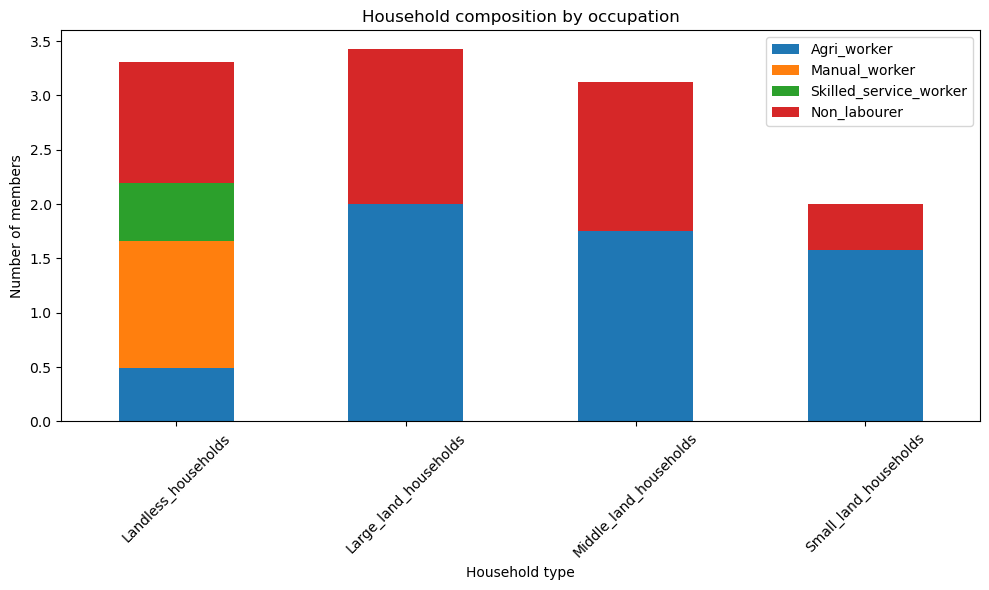

In [3]:
df = model.get_household_member_counts()

# Groepeer op household_type
grouped = df.groupby("household_type").mean()

# Combineer klasses voor de plot
grouped["Agri_worker"] = grouped["Low_skilled_agri_worker"] + grouped["Skilled_agri_worker"]
grouped["Manual_worker"] = grouped["Low_skilled_nonAgri"] + grouped["Manual_worker"] + grouped["Other"]
grouped["Skilled_service_worker"] = grouped["Skilled_service_worker"]
grouped["Non_labourer"] = grouped["Non_labourer"]

# Selecteer alleen gecombineerde kolommen voor de plot
plot_data = grouped[["Agri_worker", "Manual_worker", "Skilled_service_worker", "Non_labourer"]]

# Maak de barplot
plot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Household composition by occupation")
plt.xlabel("Household type")
plt.ylabel("Number of members")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


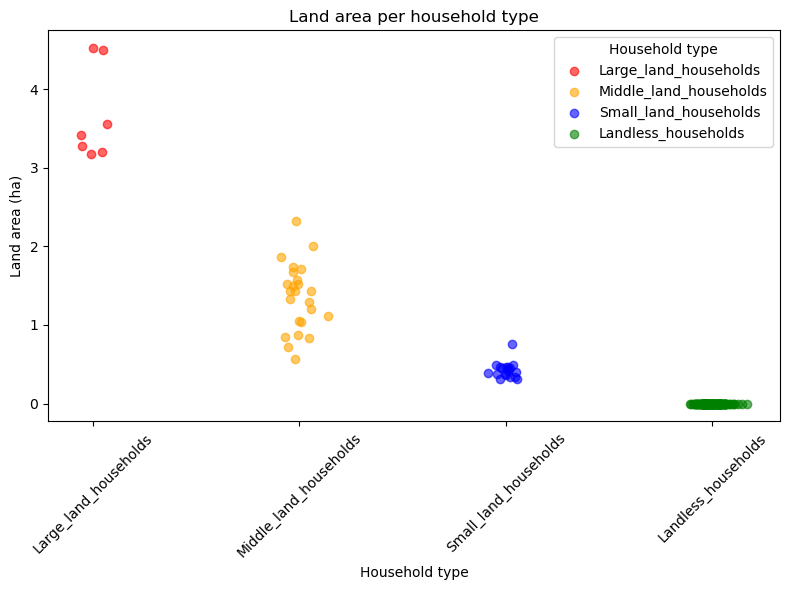

In [4]:
import matplotlib.pyplot as plt
import numpy as np

household_types = df['household_type'].unique()
color_map = {
    "Small_land_households": "blue",
    "Middle_land_households": "orange",
    "Large_land_households": "red",
    "Landless_households": "green"
}

plt.figure(figsize=(8,6))

for i, h_type in enumerate(household_types):
    subset = df[df['household_type'] == h_type]
    x = np.random.normal(i, 0.05, size=len(subset))
    y = subset['land_area']
    plt.scatter(x, y, alpha=0.6, color=color_map.get(h_type, "gray"), label=h_type)

plt.xticks(range(len(household_types)), household_types, rotation=45)
plt.xlabel("Household type")
plt.ylabel("Land area (ha)")
plt.title("Land area per household type")
plt.legend(title="Household type")
plt.tight_layout()
plt.show()


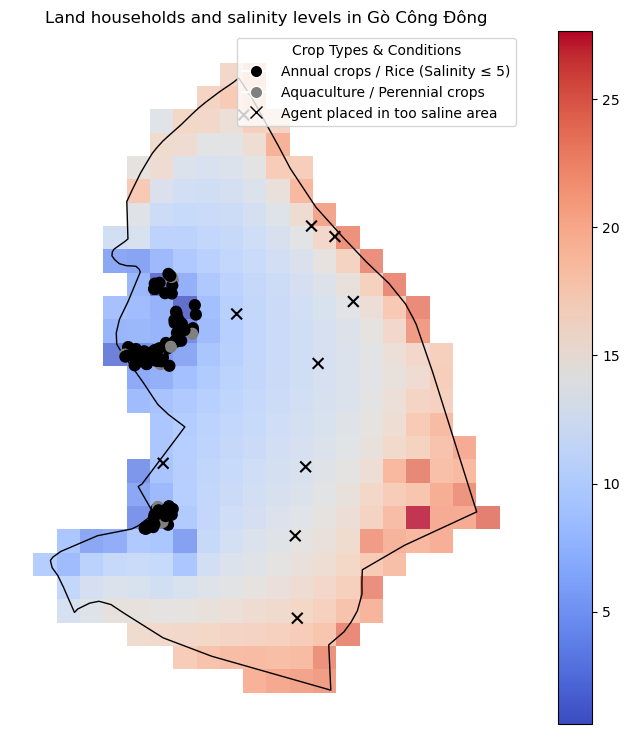

In [5]:
from Model3 import Large_land_households, Middle_land_households, Small_land_households
from collections import Counter

def plot_network_with_salinity(ax, model, salinity_threshold=5):
    ax.clear()

    # Plot salinity background
    model.data_salinity.plot(ax=ax, column="Salinity", cmap="coolwarm", alpha=0.8, legend=True)

    # Plot district boundaries
    model.polygon_districts.boundary.plot(ax=ax, color='black', linewidth=1)

    # Map node_id to land agent
    node_to_agent = {
        agent.node_id: agent for agent in model.agents
        if hasattr(agent, 'node_id') and isinstance(agent, (Large_land_households, Middle_land_households, Small_land_households))
    }

    pos = nx.get_node_attributes(model.G, 'pos')

    from shapely.geometry import Point

    def get_salinity_at_pos(xy):
        point = Point(xy)
        matches = model.data_salinity[model.data_salinity.geometry.contains(point)]
        return matches.iloc[0]['Salinity'] if not matches.empty else np.nan

    markers, colors = [], []
    for node_id in model.G.nodes():
        agent = node_to_agent.get(node_id)
        xy = pos[node_id]
        salinity = get_salinity_at_pos(xy)

        # Default values
        marker = 'o'
        color = 'lightgray'

        if agent:
            crop = getattr(agent, 'crop_type', None)

            if crop in ["Annual crops", "Rice"]:
                color = 'black'
                if salinity is not None and not np.isnan(salinity) and salinity > salinity_threshold:
                    # These agents are placed in a too saline area
                    marker = 'x'  
                else:
                    # These are the agents who are placed correct
                    marker = 'o' 
            elif crop in ["Aquaculture", "Perennial crops"]:
                color = 'gray'
                marker = 'o'
            else:
                color = 'lightgray'
                marker = 'o'

        colors.append(color)
        markers.append(marker)

    # Draw nodes grouped by marker type
    for marker_type in set(markers):
        node_list = [n for n, m in zip(model.G.nodes(), markers) if m == marker_type]
        node_colors = [c for c, m in zip(colors, markers) if m == marker_type]

        nx.draw_networkx_nodes(model.G, pos,
                               nodelist=node_list,
                               node_color=node_colors,
                               node_size=60,
                               node_shape=marker_type,
                               ax=ax)

    # Legend
    legend_elements = [
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='black', markersize=9, label='Annual crops / Rice (Salinity ≤ 5)'),
        
        mlines.Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=9, label='Aquaculture / Perennial crops'),
        mlines.Line2D([], [], marker='x', color='black', linestyle='None', markersize=9, label='Agent placed in too saline area'),
        # mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightgray', markersize=9, label='Other / No agent'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Crop Types & Conditions')
    ax.set_title(f"Land households and salinity levels in {model.district}")
    ax.axis('off')


fig, ax = plt.subplots(figsize=(9, 9))
plot_network_with_salinity(ax, initial_model_state)
plt.show()


# Experiments
It is studied which household characteristics the nonmigrated households have after 25 years, compared to the start characteristics of the household.

## Look at the data at the last step

In [6]:
df299 = model.data_at_step_299

# Crops_and_land and "Agent_occupations" are dictionaries, therefore these need to be transformed to pandas series
crop_df = df299['crops_and_land'].apply(pd.Series)
occupation_df = df299['agent_occupation'].apply(pd.Series)

# Add these new columns to the dataframe
df299 = pd.concat([df299, crop_df], axis=1)
df299

,land_area,household_size,association,livelihood,crops_and_land,agent_occupation,Rice,Maize,Shrimp,Coconut
0,3.203438,6,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 2.7328582519439504, 'Maize': 0.470579...",low_skilled_agri_worker,2.732858,0.470579,NaN,NaN
1,3.203438,6,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 2.7328582519439504, 'Maize': 0.470579...",low_skilled_agri_worker,2.732858,0.470579,NaN,NaN
2,3.203438,6,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 2.7328582519439504, 'Maize': 0.470579...",None,2.732858,0.470579,NaN,NaN
3,3.203438,6,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 2.7328582519439504, 'Maize': 0.470579...",skilled_agri_worker,2.732858,0.470579,NaN,NaN
4,3.203438,6,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 2.7328582519439504, 'Maize': 0.470579...",skilled_agri_worker,2.732858,0.470579,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
136,1.677074,3,0,"{'Human': 0.5, 'Social': 0.3574007220216607, '...","{'Rice': 1.2163011273252136, 'Maize': 0.460773...",None,1.216301,0.460773,NaN,NaN
137,0.341158,0,0,"{'Human': 0.25, 'Social': 0.3574007220216607, ...","{'Coconut': 0.34115765377370805, 'Rice': 0.170...",low_skilled_agri_worker,0.170579,NaN,NaN,0.341158
138,3.282464,1,0,"{'Human': 0.4375, 'Social': 0.3574007220216607...","{'Rice': 2.9652245081601283, 'Maize': 0.317239...",low_skilled_agri_worker,2.965225,0.317239,NaN,NaN
139,3.282464,1,0,"{'Human': 0.4375, 'Social': 0.3574007220216607...","{'Rice': 2.9652245081601283, 'Maize': 0.317239...",None,2.965225,0.317239,NaN,NaN


#### Number of households per land category and crop type

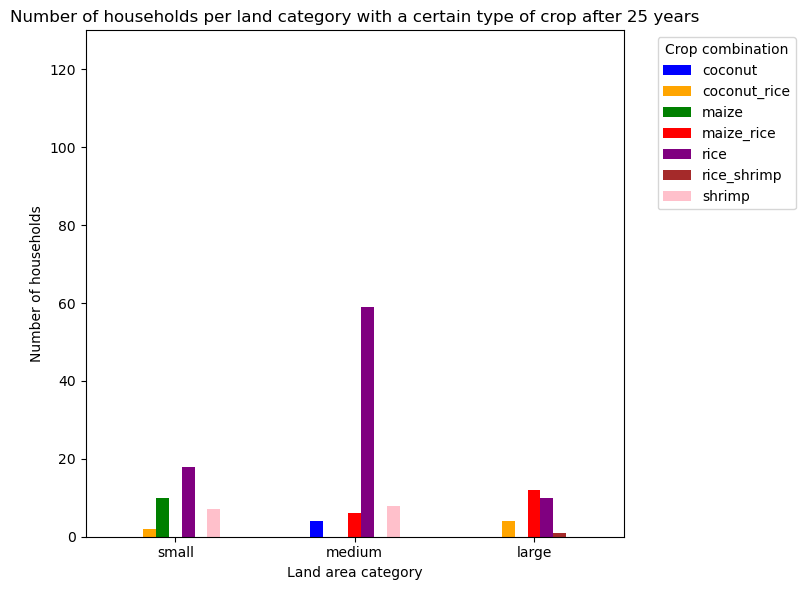

In [7]:
# Categorize the land in small, medium, large
bins = [0, 0.5, 2, 5]
labels = ['small', 'medium', 'large']
df299['land_category'] = pd.cut(df299['land_area'], bins=bins, labels=labels, include_lowest=True)

# Make it possible to have multiple crops
def combine_crops(row):
    crops = []
    if pd.notna(row['Rice']) and row['Rice'] > 0:
        crops.append('rice')
    if pd.notna(row['Maize']) and row['Maize'] > 0:
        crops.append('maize')
    if pd.notna(row['Shrimp']) and row['Shrimp'] > 0:
        crops.append('shrimp')
    if pd.notna(row['Coconut']) and row['Coconut'] > 0:
        crops.append('coconut')
    if len(crops) == 0:
        return 'none'
    else:
        return '_'.join(sorted(crops))

df299['crop_category'] = df299.apply(combine_crops, axis=1)

# Count the number of households with a certain crop
counts = df299.groupby(['land_category', 'crop_category']).size().unstack(fill_value=0)

# Set colors, to make it possible to compare with the data from the first step
colors = {
    'coconut': 'blue',
    'coconut_rice': 'orange',
    'maize': 'green',
    'maize_rice': 'red',
    'rice': 'purple',
    'rice_shrimp': 'brown',
    'shrimp': 'pink',
    'none': 'gray' 
}

plot_colors = [colors.get(col, 'gray') for col in counts.columns]

# Create a plot
counts.plot(kind='bar', stacked=False, figsize=(8,6), color=plot_colors)

plt.title('Number of households per land category with a certain type of crop after 25 years')
plt.xlabel('Land area category')
plt.ylabel('Number of households')
plt.xticks(rotation=0)
plt.ylim(0, 130)
plt.legend(title='Crop combination', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Household size

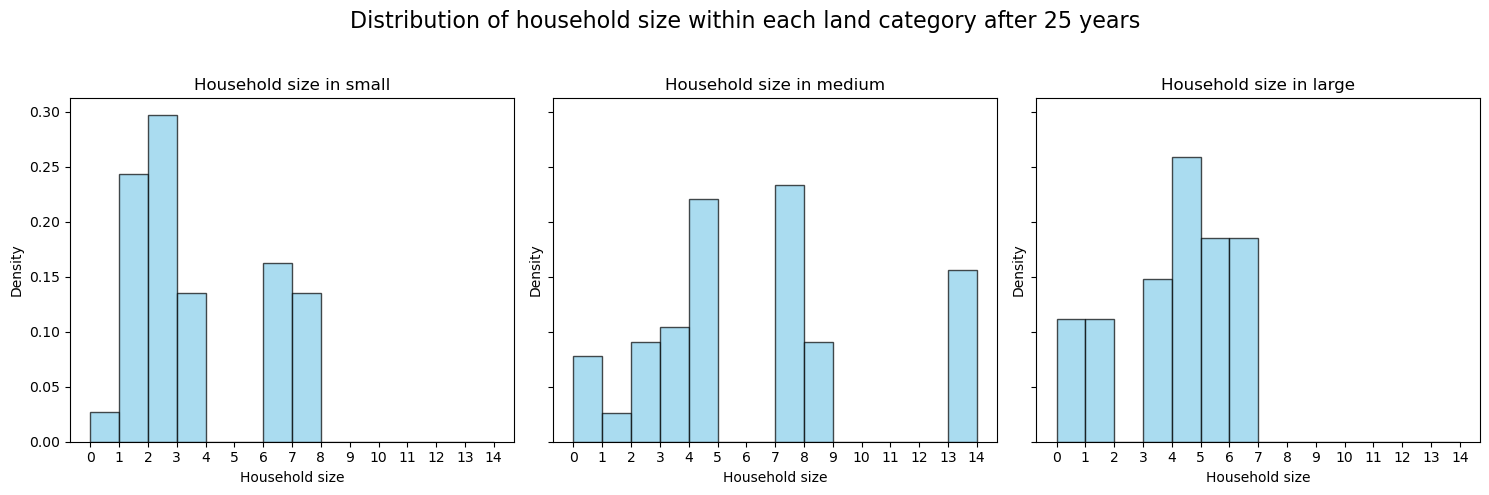

In [8]:
categories = ['small', 'medium', 'large'] 

# Create three subplots within one figure, for small, medium and large
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  

for ax, category in zip(axs, categories):
    subset = df299[df299['land_category'] == category]
    ax.hist(subset['household_size'], bins=range(0, max(df299['household_size'])+2), alpha=0.7, color='skyblue', edgecolor='black', density=True)
    ax.set_title(f'Household size in {category}')
    ax.set_xlabel('Household size')
    ax.set_ylabel('Density')
    ax.set_xticks(range(0, max(df299['household_size'])+2))

fig.suptitle('Distribution of household size within each land category after 25 years', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


#### Occupations per land category within a household

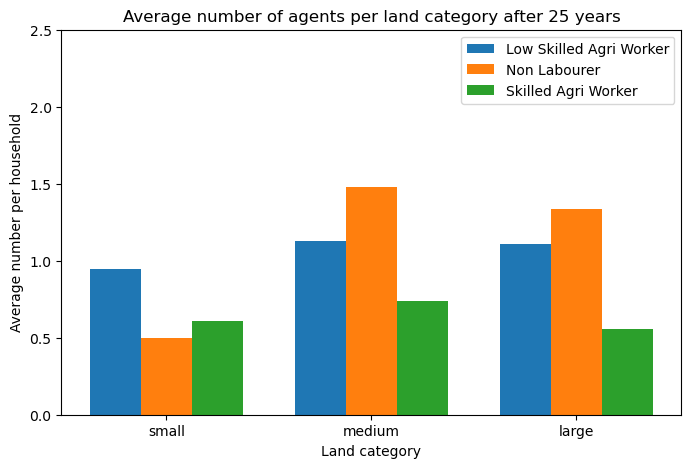

In [9]:
# Change all nan values to Non-labourers
df299['agent_occupation'] = df299['agent_occupation'].fillna('non labourer')

# Groupby land area and occupation, and count the numbers
occupation_counts = df299.groupby(['land_area', 'agent_occupation']).size().unstack(fill_value=0).reset_index()

# Create groups for small, medium and large farmers
bins = [0, 0.5, 2, 5]
labels = ['small', 'medium', 'large']
occupation_counts['land_category'] = pd.cut(occupation_counts['land_area'], bins=bins, labels=labels, include_lowest=True)

# Groupby land_category, and occupation
avg_by_category = occupation_counts.groupby('land_category')[['low_skilled_agri_worker', 'non labourer', 'skilled_agri_worker']].mean().reset_index()


categories = avg_by_category['land_category'].astype(str).tolist()
low_skilled = avg_by_category['low_skilled_agri_worker'].tolist()
non_labourer = avg_by_category['non labourer'].tolist()
skilled = avg_by_category['skilled_agri_worker'].tolist()

# Make sure the categories are properly aligned on the x-axis
x = np.arange(len(categories))  
width = 0.25

# Create plot
fig, ax = plt.subplots(figsize=(8,5))

# for low skilled agri worker, non labourer, and skilled agri worker within a household
rects1 = ax.bar(x - width, low_skilled, width, label='Low Skilled Agri Worker')
rects2 = ax.bar(x, non_labourer, width, label='Non Labourer')
rects3 = ax.bar(x + width, skilled, width, label='Skilled Agri Worker')

# Labels and title
ax.set_xlabel('Land category')
ax.set_ylabel('Average number per household')
ax.set_title('Average number of agents per land category after 25 years')
ax.set_xticks(x)
ax.set_ylim(0,2.5)
ax.set_xticklabels(categories)
ax.legend()

plt.show()




## Look at the data at step 1

#### Occupations per land category within a household
These plots are created the same way as the plots above

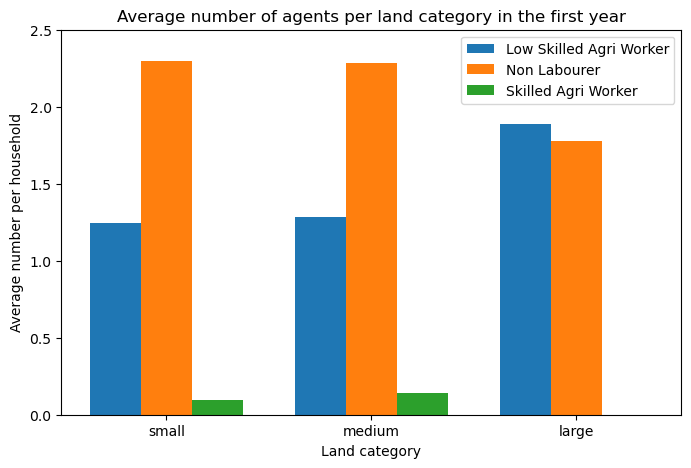

In [10]:
df1 = model.data_at_step_1

# Crops_and_land and "Agent_occupations" are dictionaries, therefore these need to be transformed to pandas series
crop_df = df1['crops_and_land'].apply(pd.Series)
occupation_df = df1['agent_occupation'].apply(pd.Series)

#add these new columns to the dataframe
df1 = pd.concat([df1, crop_df], axis=1)


# Change Nan values to Non labourer
df1['agent_occupation'] = df1['agent_occupation'].fillna('non labourer')

# Groupby land area and agent occupation, and count
occupation_counts = df1.groupby(['land_area', 'agent_occupation']).size().unstack(fill_value=0).reset_index()

# Create land categories
bins = [0, 0.5, 2, 5]
labels = ['small', 'medium', 'large']
occupation_counts['land_category'] = pd.cut(occupation_counts['land_area'], bins=bins, labels=labels, include_lowest=True)

# Group by land category and the occupations, look at the means
avg_by_category = occupation_counts.groupby('land_category')[['low_skilled_agri_worker', 'non labourer', 'skilled_agri_worker']].mean().reset_index()

categories = avg_by_category['land_category'].astype(str).tolist()
low_skilled = avg_by_category['low_skilled_agri_worker'].tolist()
non_labourer = avg_by_category['non labourer'].tolist()
skilled = avg_by_category['skilled_agri_worker'].tolist()

# Make sure the categories are properly aligned on the x-axis
x = np.arange(len(categories)) 
width = 0.25  

# Create plot
fig, ax = plt.subplots(figsize=(8,5))

# Add the bars for the different occupations
rects1 = ax.bar(x - width, low_skilled, width, label='Low Skilled Agri Worker')
rects2 = ax.bar(x, non_labourer, width, label='Non Labourer')
rects3 = ax.bar(x + width, skilled, width, label='Skilled Agri Worker')

# add labels and title
ax.set_xlabel('Land category')
ax.set_ylabel('Average number per household')
ax.set_title('Average number of agents per land category in the first year')
ax.set_xticks(x)
ax.set_ylim(0,2.5)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

#### Number of households per land category and crop type

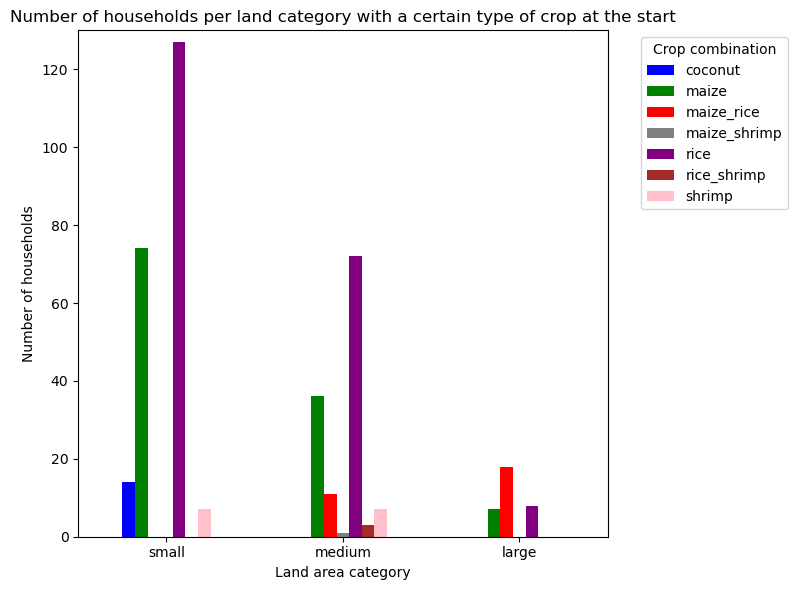

In [11]:
# Create bins for small, medium, large
bins = [0, 0.5, 2, 5]
labels = ['small', 'medium', 'large']
df1['land_category'] = pd.cut(df1['land_area'], bins=bins, labels=labels, include_lowest=True)

# Make it possible to have multiple crops within 1 household
def combine_crops(row):
    crops = []
    if pd.notna(row['Rice']) and row['Rice'] > 0:
        crops.append('rice')
    if pd.notna(row['Maize']) and row['Maize'] > 0:
        crops.append('maize')
    if pd.notna(row['Shrimp']) and row['Shrimp'] > 0:
        crops.append('shrimp')
    if pd.notna(row['Coconut']) and row['Coconut'] > 0:
        crops.append('coconut')
    if len(crops) == 0:
        return 'none'
    else:
        return '_'.join(sorted(crops))

df1['crop_category'] = df1.apply(combine_crops, axis=1)

# count the number of households per land category and crop type
counts = df1.groupby(['land_category', 'crop_category']).size().unstack(fill_value=0)

# Set colors for each crop combination
colors = {
    'coconut': 'blue',
    'coconut_rice': 'orange',
    'maize': 'green',
    'maize_rice': 'red',
    'rice': 'purple',
    'rice_shrimp': 'brown',
    'shrimp': 'pink'
}

plot_colors = [colors.get(col, 'gray') for col in counts.columns]

# Create barplot
counts.plot(kind='bar', stacked=False, figsize=(8,6), color=plot_colors)

plt.title('Number of households per land category with a certain type of crop at the start')
plt.xlabel('Land area category')
plt.ylabel('Number of households')
plt.ylim(0, 130)
plt.xticks(rotation=0)
plt.legend(title='Crop combination', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Household size

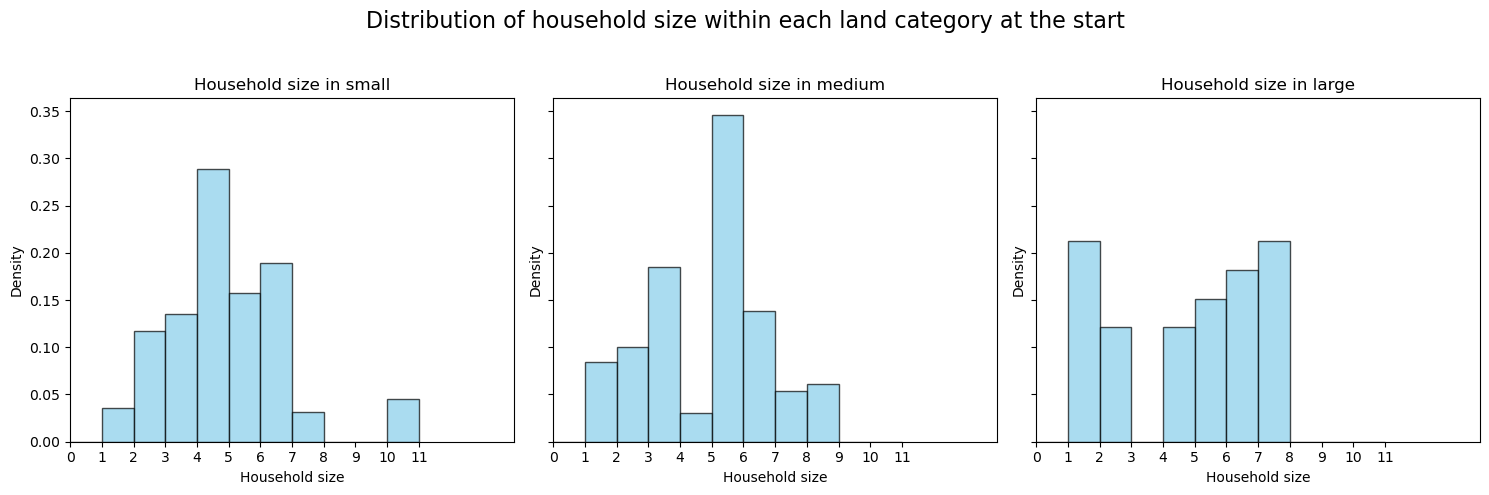

In [12]:
# Look at small, medium, large
categories = ['small', 'medium', 'large']  

# Create plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True) 

for ax, category in zip(axs, categories):
    subset = df1[df1['land_category'] == category]
    ax.hist(subset['household_size'], bins=range(0, max(df1['household_size'])+2), alpha=0.7, color='skyblue', edgecolor='black', density=True)
    ax.set_title(f'Household size in {category}')
    ax.set_xlabel('Household size')
    ax.set_ylabel('Density')
    ax.set_xticks(range(0, max(df1['household_size'])+2))
    ax.set_xlim(0,14)

fig.suptitle('Distribution of household size within each land category at the start', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # ruimte laten voor suptitle
plt.show()
